## We recognize the connecting points
## We calculate TCM
## We calculate the clusters directly from the distance's matrix

In [1]:
library("Mapper")
library("igraph")
library("pals")
library("gtools")
library("RcppCNPy")
library("stringr")
require("plotrix") 
library("lattice")
library("Rglpk")
library("matlab")
source("functions-R.R") #Functions


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘gtools’


The following object is masked from ‘package:igraph’:

    permute


Loading required package: plotrix

Loading required package: slam

Using the GLPK callable library version 4.65


Attaching package: ‘matlab’


The following object is masked from ‘package:stats’:

    reshape


The following objects are masked from ‘package:utils’:

    find, fix


The following object is masked from ‘package:base’:

    sum




In [2]:
suspense=npyLoad("../Data/avg_suspense.npy")
length(suspense)

[1] 193

In [3]:
mappers=Sys.glob("../Data/mapper/*.rds")
mappers

[1] "../Data/mapper/all_l1_cmds.rds"       
[2] "../Data/mapper/all_l1_iso_rand.rds"   
[3] "../Data/mapper/all_l1_mmds.rds"       
[4] "../Data/mapper/all_l1-nothres_iso.rds"
[5] "../Data/mapper/all_l1_se.rds"         
[6] "../Data/mapper/all_l1-thres_iso.rds"

In [4]:
m = readRDS(mappers[6])

In [5]:
i=18

In [6]:
m[[i]]

Fixed Interval Cover: (number intervals = [6, 6], percent overlap = [35, 35]%)

In [7]:
graph=m[[i]]$graph
vert=m[[i]]$vertices

## Detection of connecting points
Points that when they are removed the graph has one more connected component (path connected)

In [8]:
connectors(graph)

[1]  6 10 15 26 37 39

## Degree

In [55]:
deg=degree(graph)
sort(deg)

13 19 37 48 49  0  1  2  3  6  8 10 15 16 18 20 22 23 24 26 30 31 34 39 43 44 
 1  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3 
46 47 51  5  7 11 21 25 29 36 42 45 50  4 17 28 32 33 35 40 41 14 27 12 38  9 
 3  3  3  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  6  6  7  8 12

In [56]:
mean(deg)

[1] 3.846154

## TCM

In [9]:
i=18

In [10]:
m[[i]]
vert=m[[i]]$vertices
adj=m[[i]]$edges
M=tcm_matrix(vert,adj)
#save(M,file="../Data/all_l1_iso_tcm_6_35.RData")

Fixed Interval Cover: (number intervals = [6, 6], percent overlap = [42, 42]%)

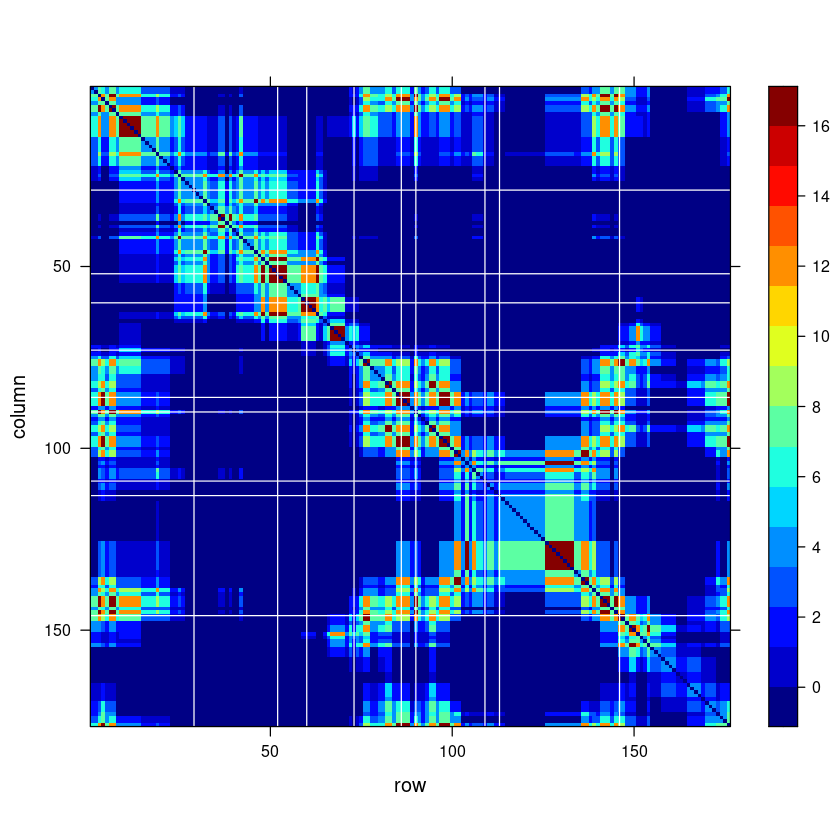

In [11]:
blocks=c(29,52,60,73,86,90,109,113,146)
par=(pin=c(8,7))
levelplot(M,col.regions=jet.colors(100),ylim=rev(c(0.5, 176.5)),
         panel = function(...){
            panel.levelplot(...)
            panel.abline(v = blocks,h= blocks,lwd=1,col='white')} 
         )

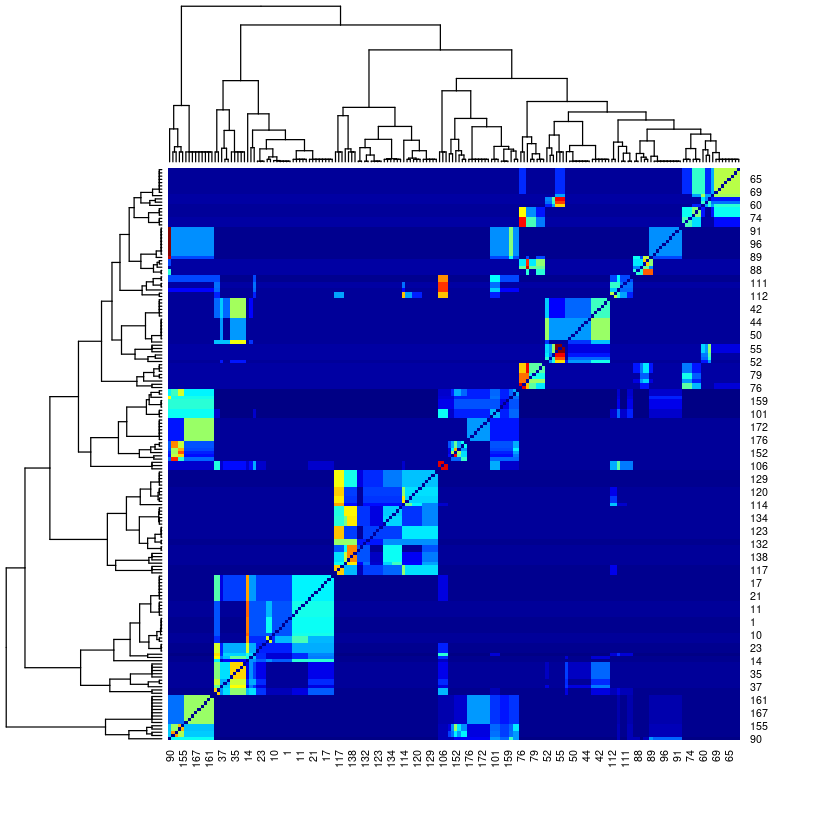

In [14]:
heatmap(M,distfun = function(x) dist(x,method = 'manhattan'),hclustfun = function(x) hclust(x,method = 'complete'),col=jet.colors(100))

### Recognize blocks using clustering

In [8]:
D=dist(M, method = "manhattan" )

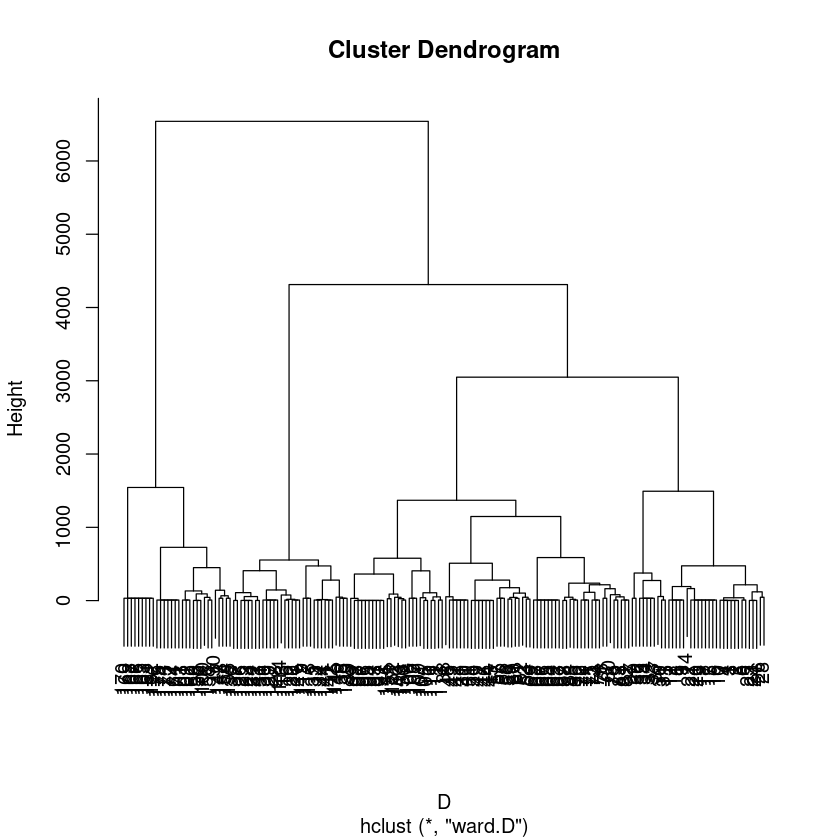

In [9]:
hcl1=hclust(D,method='ward.D')
plot(hcl1)

In [10]:
# n <- nrow(hcl[[2]]$merge)+1L
# density_params <- list(adjust=1.5)
# if (is.null(density_params$n)){ density_params$n <- min(c(2^ceiling(log(n)/log(2)), 512L)) }
# density_params$x <- hcl[[2]]$height
# f_h <- do.call(stats::density, density_params)
# plot(f_h)

In [11]:
hcl=list()
hcl[[1]]=hclust(D,method='average')
hcl[[2]]=hclust(D,method='complete')
hcl[[3]]=hclust(D,method='ward.D')

eps=list()
eps[[1]]=cutoff_first_threshold(hcl[[1]],adjust=1)
eps[[2]]=cutoff_first_threshold(hcl[[2]],adjust=2)
eps[[3]]=cutoff_first_threshold(hcl[[3]],adjust=1)
eps[[3]]=5000

mega_blocks=list()
for (i in 1:3){
    vector=cutree(hcl[[i]], h = eps[[i]])   
    c=length(unique(vector))
    cluster=list()
    for (j in 1:c){
        cluster[[j]]=which(vector == j, arr.ind = TRUE)
    }
   
    mega_blocks[[i]]=lapply(cluster,recog_block)
}

In [12]:
mega_blocks

vec,1,176
vec,1,176
vec,1,89
vec,91,99
vec,104,146
vec,149,153
vec,90,90
vec,100,103
vec,147,148
vec,154,176


In [21]:
blocks=mega_blocks[[3]]
save(blocks,file="../Data/blocks.Rdata")

## Can we recover the clusters from distance matrix?

In [8]:
og_dist=npyLoad("../Data/dist/all_l1-thres.npy")
nrow(og_dist)

[1] 176

In [9]:
dend1 <- as.dendrogram(hc)

plot(dend2$upper)

ERROR: Error in as.dendrogram(hc): objeto 'hc' no encontrado


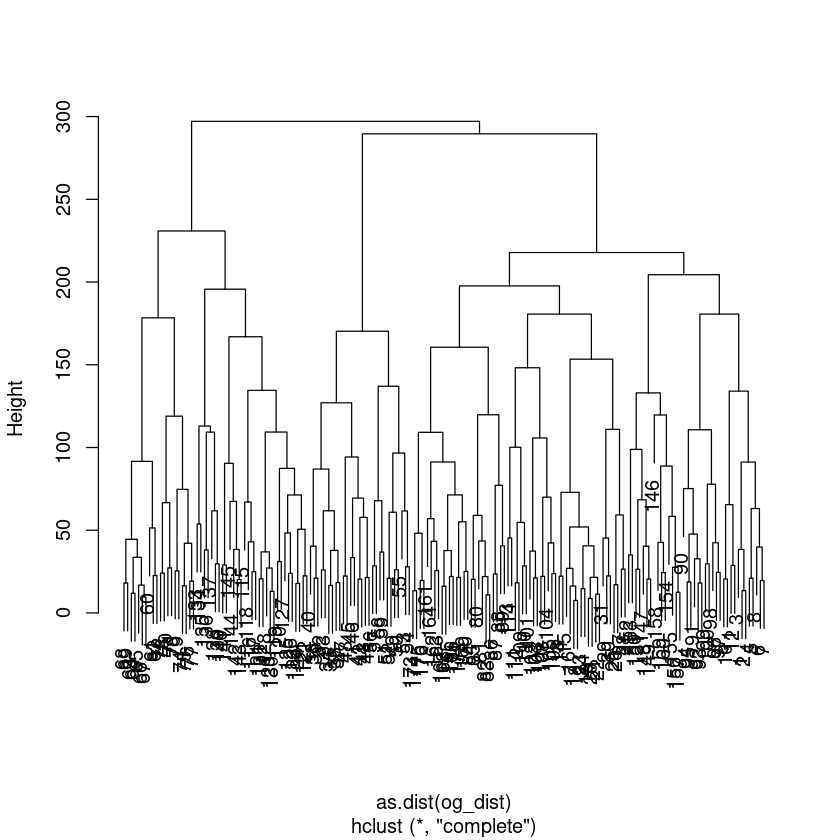

In [10]:
hcl=hclust(as.dist(og_dist),method='complete')
#pdf("../Imagenes/thesis/dendo_rows.pdf",width=7,height=8)
plot(hcl,sub=NULL,xlab=NULL,main="")
#dev.off()

In [25]:
#eps1=cutoff_first_threshold(hcl,adjust=1)
eps1=250
vector1=cutree(hcl, h = eps1)
c1=length(unique(vector1))
clusters1=list()
for (i in 1:c1){
    clusters1[[i]]=which(vector1 == i, arr.ind = TRUE)
}

In [21]:
mega_blocks1=lapply(clusters1,recog_block)
mega_blocks1

vec,1,31
vec,80,114
vec,146,176
vec,32,59
vec,60,79
vec,115,145
